# Big Data in Finance II  Group Assignment

**Group 8, Big Data in Finance II, Imperial College London**

# Table of Content

- [Required Libraries](#required-libraries)
- [Data Preprocessing](#data-preprocessing)
- [Questions 1](#questions-1)
  - [Define Utility Functions](#define-utility-functions)
  - [Define Neural Network Models and Trainers](#define-neural-network-models-and-trainers)
  - [Training (yearly recursive refit)](#training-yearly-recursive-refit)
    - [Training NN2](#training-nn2)
    - [Training NN3](#training-nn3)
    - [Training NN4](#training-nn4)
- [Questions 2](#questions-2)
- [Questions 3](#questions-3)
  - [Questions 3a](#questions-3a)
  - [Questions 3b](#questions-3b)
  - [Questions 3c](#questions-3c)
- [Questions 4](#questions-4)
- [Questions 5](#questions-5)

# Required Libraries

In [1]:
import pickle
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

seed = 9

# Data Preprocessing

In [2]:
stock_chara_panel_df = pd.read_pickle('../returns_chars_panel.pkl') 
macro_ts_df = pd.read_pickle('../macro_timeseries.pkl') 

In [3]:
data_df = pd.merge(stock_chara_panel_df, macro_ts_df, on='date', how='left', suffixes=['_chara','_macro']) 

In [4]:
data_df.shape

(3739449, 110)

In [5]:
data_df.isna().any().any()

False

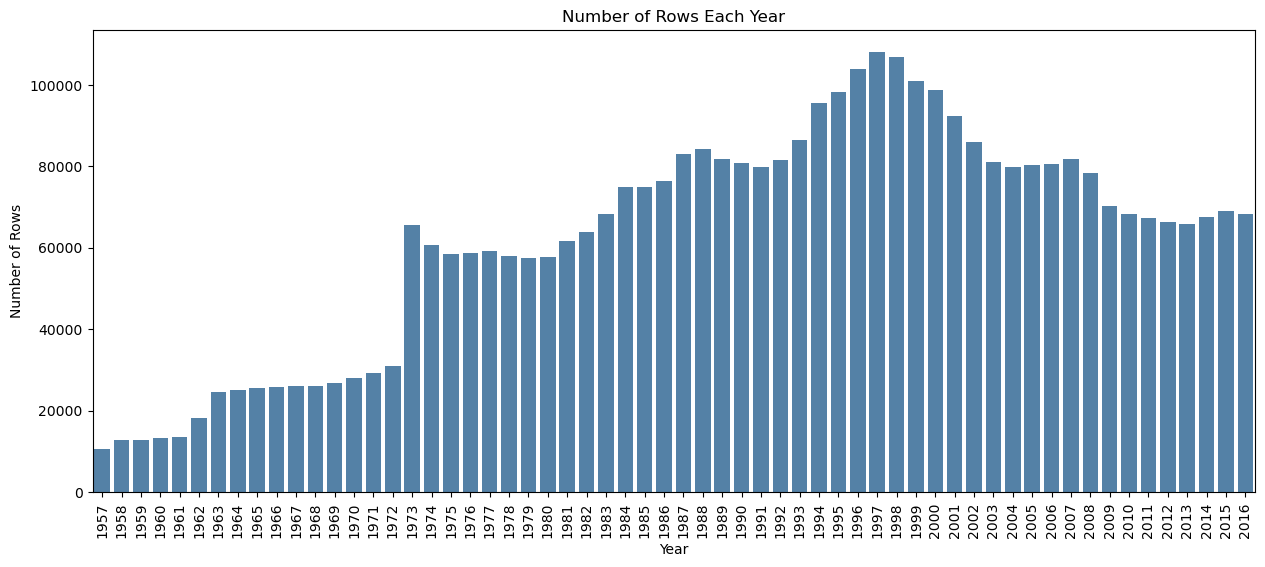

In [6]:
year_counts = data_df['date'].dt.year.value_counts()
plt.figure(figsize=(15, 6))
sns.barplot(x=year_counts.index, y=year_counts.values, color='steelblue')
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.title('Number of Rows Each Year')
plt.xticks(rotation=90, fontsize=10)  
plt.show()

# Questions 1

*In the data used by Gu, Kelly and Xiu (RFS 2019 – provided in class), use a similar procedure to theirs to predict stock returns with neural networks. Start by finding a suitable baseline configuration, and use a validation procedure to pick optimal hyperparameters for three neural network models: One with 2 hidden layers, one with 3 hidden layers, and one with 4 hidden layers.*

## Define Utility Functions

In [7]:
def generate_recursive_dataset(data_df, 
    i_th_recursion = 0,
    train_time_span = 18,
    val_time_span = 12,
    test_time_span = 1,
    verbose=False):
    '''
    Replication of Gu, Kelly and Xiu (2019) recursive data generation process for yearly recursive refit and OOS evaluation.
    The function start generating training, validation and validation dataset start from the min(date) of the input dataset.
    The function should be used in side a loop iterating i_th recursion years, example:
    
    recursion_range = 29
    for i_th_recursion in range(0, recursion_range):
        ... = recursive_dataset(..., i_th_recursion = i_th_recursion)
    '''
    data_min_date = data_df['date'].min()
    
    train_start_year = data_min_date.year
    month = data_min_date.month
    train_start_time = f"{train_start_year}-{month}"

    train_end_year = train_start_year + train_time_span + i_th_recursion
    train_end_time = f"{train_end_year}-{month}"

    val_end_year = train_end_year + val_time_span
    val_end_time = f"{val_end_year}-{month}"

    test_end_year = val_end_year + test_time_span
    test_end_time = f"{test_end_year}-{month}"

    train_df = data_df[(data_df['date'] >= train_start_time) & (data_df['date'] < train_end_time)]
    val_df = data_df[(data_df['date'] >= train_end_time) & (data_df['date'] < val_end_time)]
    test_df = data_df[(data_df['date'] >= val_end_time) & (data_df['date'] < test_end_time)]

    X_train = train_df.drop(columns=["ret", "excess_ret", "rfree", "permno", "date"])
    y_train = train_df["excess_ret"]

    X_val = val_df.drop(columns=["ret", "excess_ret", "rfree", "permno", "date"])
    y_val = val_df["excess_ret"]
    
    X_test = test_df.drop(columns=["ret", "excess_ret", "rfree", "permno", "date"])
    y_test = test_df["excess_ret"]

    if verbose:
        print(f"train_start_time: {train_start_time}, train_end_time: {train_end_time}")
        print(f"val_start_time: {train_end_time}, val_end_time: {val_end_time}")
        print(f"test_start_time: {val_end_time}, test_end_time: {test_end_time}")

    meta_data_dict = {
        'train_start_time': train_start_time,
        'train_end_time': train_end_time,
        'val_start_time': train_end_time,
        'val_end_time': val_end_time,
        'test_start_time': val_end_time,
        'test_end_time': test_end_time
    }

    return X_train.values, y_train.values.reshape(-1, 1), X_val.values, y_val.values.reshape(-1, 1), X_test.values, y_test.values.reshape(-1, 1), meta_data_dict

In [8]:
def prepare_recursive_dateset_for_NN_training(data_df, batch_size = 10000, i_th_recursion = 0, train_time_span = 18, val_time_span = 12, test_time_span = 1, verbose=False):
    '''
    convert data to tensor and prepare dataloader NN training
    '''
    X_train, y_train, X_val, y_val, X_test, y_test, meta_data_dict = generate_recursive_dataset(
        data_df, 
        i_th_recursion = i_th_recursion, 
        train_time_span = train_time_span,
        val_time_span = val_time_span,
        test_time_span = test_time_span,
        verbose=verbose)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, X_test, y_test, meta_data_dict

In [9]:
def R2_no_demeaning_NN(model, X, y, device):
    '''
    calculate R2 without demeaning (GKX 2019, R2 equation 19)
    if input is test set, the output is out-of-sample R2 (R2oos)
    assume X and y are tensors
    '''
    X = X.to(device)
    y = y.to(device)
    model.eval()  
    with torch.no_grad():
        y_pred = model(X)
        # Calculate prediction errors and squared errors
        prediction_errors = y - y_pred
        squared_errors = prediction_errors ** 2
        # Sum of squared prediction errors (numerator)
        numerator = squared_errors.sum().item()

        # Sum of squared excess returns (denominator)
        squared_excess_returns = y ** 2
        denominator = squared_excess_returns.sum().item()
        
        # Calculate R2
        R2 = 1 - (numerator / denominator)
    return R2

def R2_demeaning_NN(model, X, y, device):
    '''
    calculate R2oos for the out-of-sample test set with demeaning
    assume X and y are tensors
    '''
    X = X.to(device)
    y = y.to(device)
    model.eval()  
    with torch.no_grad():
        y_pred = model(X)
        # Calculate prediction errors and squared errors
        prediction_errors = y - y_pred
        squared_errors = prediction_errors ** 2
        # Sum of squared prediction errors (numerator)
        numerator = squared_errors.sum().item()
        
        # Mean of excess returns
        mean_excess_returns = y.mean().item()
        # Squared differences from the mean for excess returns
        squared_excess_returns = (y - mean_excess_returns) ** 2
        # Sum of squared excess returns (denominator)
        denominator = squared_excess_returns.sum().item()
        
        # Calculate the out-of-sample R^2
        R2 = 1 - (numerator / denominator)
    return R2

In [10]:
def apply_regularization(loss, model, reg_type='L1', reg_lambda=0.01):
    '''
    Apply L1 or L2 regularization to the loss function.
    '''
    if reg_type == 'L1':
        l1_penalty = sum(torch.sum(param.abs()) for param in model.parameters())
        loss += reg_lambda * l1_penalty
    elif reg_type == 'L2':
        l2_penalty = sum(torch.sum(param.pow(2)) for param in model.parameters())
        loss += reg_lambda * l2_penalty
    return loss

## Define Neural Network Models and Trainers

In [11]:
class NN_Flexiable(nn.Module):
    def __init__(self, input_dim, output_dim = 1, num_layers = 4, max_hidden_dim = 64, activation='LeakyReLU', w_init='kaiming_uniform_'):
        super(NN_Flexiable, self).__init__()
        # Initialize layers, geometric pyramid rule applied for hidden dimension
        self.num_layers = num_layers
        self.m_list = nn.ModuleList()
        self.hidden_dim_list = [max_hidden_dim // (2 ** i) for i in range(num_layers)]
        # Define first layer
        self.m_list.append(nn.Linear(input_dim, self.hidden_dim_list[0]))
        self.m_list.append(nn.BatchNorm1d(self.hidden_dim_list[0]))
        # Define hidden layers
        for i in range(1, num_layers):
            self.m_list.append(nn.Linear(self.hidden_dim_list[i - 1], self.hidden_dim_list[i]))
            self.m_list.append(nn.BatchNorm1d(self.hidden_dim_list[i]))
        # Define output layer
        self.m_list.append(nn.Linear(self.hidden_dim_list[-1], output_dim))
        # Define activation function
        if activation == 'LeakyReLU':
            self.activation = nn.LeakyReLU()
        elif activation == 'ReLU':
            self.activation = nn.ReLU()
        else:
            raise ValueError("Unsupported activation function")
        # Initialize weights
        if w_init:
            if activation == 'LeakyReLU':
                self.w_init_nonlinearity = "leaky_relu"
            if activation == 'ReLU':
                self.w_init_nonlinearity = "relu"
            self.initialize_weights(w_init, self.w_init_nonlinearity)

    def initialize_weights(self, w_init, w_init_nonlinearity):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if w_init == 'kaiming_uniform_':
                    nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity=w_init_nonlinearity)
                elif w_init == 'kaiming_normal_':
                    nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity=w_init_nonlinearity)
                else:
                    raise ValueError("Unsupported weight initialization method")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        # Forward pass, activation before batch normalisation, GKX 2019 implementation
        for i in range(0, len(self.m_list) - 1, 2):
            x = self.m_list[i](x)
            x = self.activation(x)
            x = self.m_list[i + 1](x)
        x = self.m_list[-1](x) # No activation on the output layer
        return x

In [12]:
def start_recursive_training(oos_year, model, optimizer, criterion, num_epochs, patience, reg_type, reg_lambda, train_loader, val_loader, X_test, y_test, device, verbose=False):
    '''
    single recursive training, validate on validation set to select best epoch, report oos performance for the best validation model for true oos performance measurement
    '''
    lowest_epoch_eval_loss = float('inf')
    best_model_state_dict = None
    best_model = None
    patience_counter = 0
    for epoch in tqdm(range(num_epochs)):
        model.train() # set model to training mode
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss = apply_regularization(loss, model, reg_type=reg_type, reg_lambda=reg_lambda)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)

        model.eval() # set model to evaluation mode
        epoch_eval_loss = 0.0
        with torch.no_grad(): # disable gradient calculation for efficiency
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_eval_loss += loss.item() * inputs.size(0)
        epoch_eval_loss /= len(val_loader.dataset)

        if epoch_eval_loss < lowest_epoch_eval_loss:
            lowest_epoch_eval_loss = epoch_eval_loss
            best_model_state_dict = model.state_dict()
            best_model = model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch: {epoch}')
                break
    
    # get all validation data from loader the calculate validation R2
    X_val = [] 
    y_val = []
    for inputs, targets in val_loader:
        X_val.append(inputs)
        y_val.append(targets)
    X_val = torch.cat(X_val, dim=0)
    y_val = torch.cat(y_val, dim=0)
    R2val_no_demeaning = R2_no_demeaning_NN(best_model, X_val, y_val, device)
    R2val_demeaning = R2_demeaning_NN(best_model, X_val, y_val, device)
    # out of sample R2 of best validation model
    R2oos_no_demeaning = R2_no_demeaning_NN(best_model, X_test, y_test, device) 
    R2oos_demeaning = R2_demeaning_NN(best_model, X_test, y_test, device) 
    if verbose:
        print(f'Eval loss: {lowest_epoch_eval_loss}, OOS year: {oos_year}')
        print(f'R2val_no_demeaning: {R2val_no_demeaning}')
        print(f'R2val_demeaning: {R2val_demeaning}')
        print(f'OSS year {oos_year}, R2oos_no_demeaning: {R2oos_no_demeaning}')
        print(f'OSS year {oos_year}, R2oos_demeaning: {R2oos_demeaning}')
    return lowest_epoch_eval_loss, R2val_no_demeaning, R2val_demeaning, R2oos_no_demeaning, R2oos_demeaning, best_model_state_dict

In [13]:
def recursive_NN_trainer(data_df, performance_and_model_dict, config_search_space, recursion_range=30, train_time_span = 18, val_time_span =12, test_time_span = 1, training_verbose = False):
    '''
    recursive training loop, search best confit each recursion, report validation R2 and OOS R2 on the fly
    '''
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for i_th_recursion in range(0, recursion_range):
        best_R2val_no_demeaning = -float('inf') # search for best validation R2 instead of OOS R2 to mimic true out-of-sample environment
        
        for config in config_search_space:
            # unpack config_search_space from config
            seed = config["seed"]
            input_dim = config["input_dim"]
            output_dim = config["output_dim"]
            num_layers = config["num_layers"]
            max_hidden_dim = config["max_hidden_dim"]
            activation = config["activation"]
            w_init = config["w_init"]
            criterion_name = config["criterion"]
            optimizer_name = config["optimizer"]
            learning_rate = config["learning_rate"]
            weight_decay = config["weight_decay"]
            regularization = config["regularization"]
            reg_lambda = config["reg_lambda"]
            batch_size = config["batch_size"]
            num_epochs = config["num_epochs"]
            patience = config["patience"]

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            train_loader, val_loader, X_test, y_test, meta_data_dict = prepare_recursive_dateset_for_NN_training(
                data_df, batch_size = batch_size, 
                i_th_recursion = i_th_recursion, 
                train_time_span = train_time_span,
                val_time_span = val_time_span,
                test_time_span = test_time_span,
                verbose=training_verbose)

            model = NN_Flexiable(input_dim=input_dim, output_dim=output_dim, num_layers=num_layers, max_hidden_dim=max_hidden_dim, activation=activation, w_init=w_init).to(device)
            OptimizerClass = getattr(optim, optimizer_name)
            CriterionClass = getattr(nn, criterion_name)
            optimizer = OptimizerClass(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
            criterion = CriterionClass()
            oos_year = meta_data_dict['test_start_time'][:4]
            if training_verbose:
                print(f"Training model for OOS year: {oos_year}")
                print(f"Configs: {config}")
                # print(f"Model: {model}")
            lowest_epoch_eval_loss, R2val_no_demeaning, R2val_demeaning, R2oos_no_demeaning, R2oos_demeaning, best_model_state_dict = start_recursive_training(oos_year,
                model, optimizer, criterion, num_epochs, patience, regularization, reg_lambda,train_loader, val_loader, X_test, y_test, device, verbose=training_verbose)

            if R2val_no_demeaning > best_R2val_no_demeaning:
                best_R2val_no_demeaning = R2val_no_demeaning

                best_R2val_demeaning = R2val_demeaning
                best_search_R2oos_no_demeaning = R2oos_no_demeaning
                best_search_R2oos_demeaning = R2oos_demeaning
                best_search_eval_loss = lowest_epoch_eval_loss
                best_search_model_state_dict = best_model_state_dict
                best_config = config

        performance_and_model_dict[oos_year] = {
                                    "R2val_no_demeaning": best_R2val_no_demeaning,
                                    "R2val_demeaning": best_R2val_demeaning,
                                    "R2oos_no_demeaning": best_search_R2oos_no_demeaning, 
                                    "R2oos_demeaning": best_search_R2oos_demeaning,
                                    "lowest_epoch_eval_loss": best_search_eval_loss,
                                    "best_model_state_dict": best_search_model_state_dict,
                                    "best_config": best_config,
                                    "i_th_recursion": i_th_recursion}
    return performance_and_model_dict

## Training (yearly recursive refit)

### Training NN2

In [35]:
NN2_config_search_space_dict = {
    "seed": [9],
    "input_dim": [105],
    "output_dim": [1],
    "num_layers": [2],
    "max_hidden_dim": [32],
    "activation": ["ReLU"],
    "w_init": [False],
    "criterion": ["MSELoss"],
    "optimizer": ["Adam"],
    "weight_decay": [0],
    "learning_rate": [0.01, 0.001],
    "regularization": ["L1"],
    "reg_lambda": [0.01, 0.001],
    "batch_size": [10000],
    "num_epochs": [100],
    "patience": [5],
}
NN2_config_search_space_dict_list = list(ParameterGrid(NN2_config_search_space_dict))

In [36]:
NN2_performance_and_model_dict = {}

In [ ]:
NN2_performance_and_model_dict = recursive_NN_trainer(data_df, 
                                                    NN2_performance_and_model_dict, 
                                                    NN2_config_search_space_dict_list, 
                                                    recursion_range = 30, 
                                                    train_time_span = 29, 
                                                    val_time_span = 1, 
                                                    test_time_span = 1, 
                                                    training_verbose = False)
# model check point
# with open('NN2_performance_and_model_dict.pkl', 'wb') as f:
#     pickle.dump(NN2_performance_and_model_dict, f)

In [38]:
NN2_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in NN2_performance_and_model_dict.items()}
NN2_R2oos_no_demeaning_df = pd.DataFrame(list(NN2_R2oos_no_demeaning_dict.items()), columns=['Year', 'NN2_R2oos']).sort_values(by='Year', ascending=True)

In [39]:
NN2_R2oos_no_demeaning_mean = np.mean([value for key, value in NN2_R2oos_no_demeaning_dict.items()])
print(f"Mean R2oos_no_demeaning: {NN2_R2oos_no_demeaning_mean}")

Mean R2oos_no_demeaning: -0.00033556838227349894


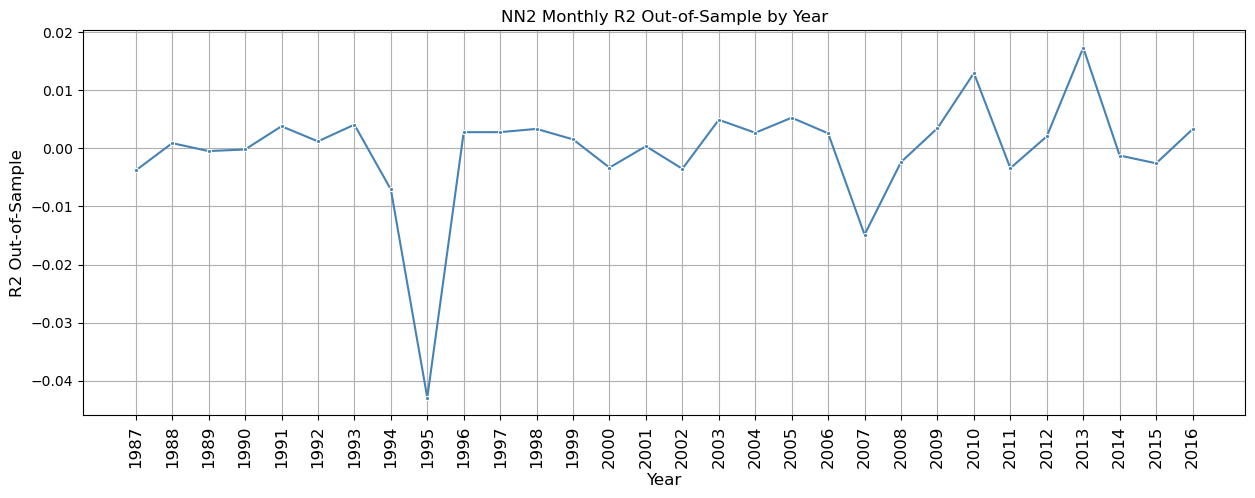

In [40]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='Year', y='NN2_R2oos', data=NN2_R2oos_no_demeaning_df, color='steelblue', marker='.')
plt.title('NN2 Monthly R2 Out-of-Sample by Year', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('R2 Out-of-Sample', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.grid()
plt.show()

### Training NN3

In [41]:
NN3_config_search_space_dict = {
    "seed": [9],
    "input_dim": [105],
    "output_dim": [1],
    "num_layers": [3],
    "max_hidden_dim": [32],
    "activation": ["ReLU"],
    "w_init": [False],
    "criterion": ["MSELoss"],
    "optimizer": ["Adam"],
    "weight_decay": [0],
    "learning_rate": [0.01, 0.001],
    "regularization": ["L1"],
    "reg_lambda": [0.01, 0.001],
    "batch_size": [10000],
    "num_epochs": [100],
    "patience": [5],
}
NN3_config_search_space_dict_list = list(ParameterGrid(NN3_config_search_space_dict))

In [42]:
NN3_performance_and_model_dict = {}

In [ ]:
NN3_performance_and_model_dict = recursive_NN_trainer(data_df, 
                                                    NN3_performance_and_model_dict, 
                                                    NN3_config_search_space_dict_list, 
                                                    recursion_range = 30, 
                                                    train_time_span = 29, 
                                                    val_time_span = 1, 
                                                    test_time_span = 1, 
                                                    training_verbose = False)
# model check point
# with open('NN3_performance_and_model_dict.pkl', 'wb') as f:
#     pickle.dump(NN3_performance_and_model_dict, f)

In [44]:
NN3_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in NN3_performance_and_model_dict.items()}
NN3_R2oos_no_demeaning_df = pd.DataFrame(list(NN3_R2oos_no_demeaning_dict.items()), columns=['Year', 'NN3_R2oos']).sort_values(by='Year', ascending=True)

In [45]:
NN3_R2oos_no_demeaning_mean = np.mean([value for key, value in NN3_R2oos_no_demeaning_dict.items()])
print(f"Mean R2oos_no_demeaning: {NN3_R2oos_no_demeaning_mean}")

Mean R2oos_no_demeaning: 0.0007163948906042032


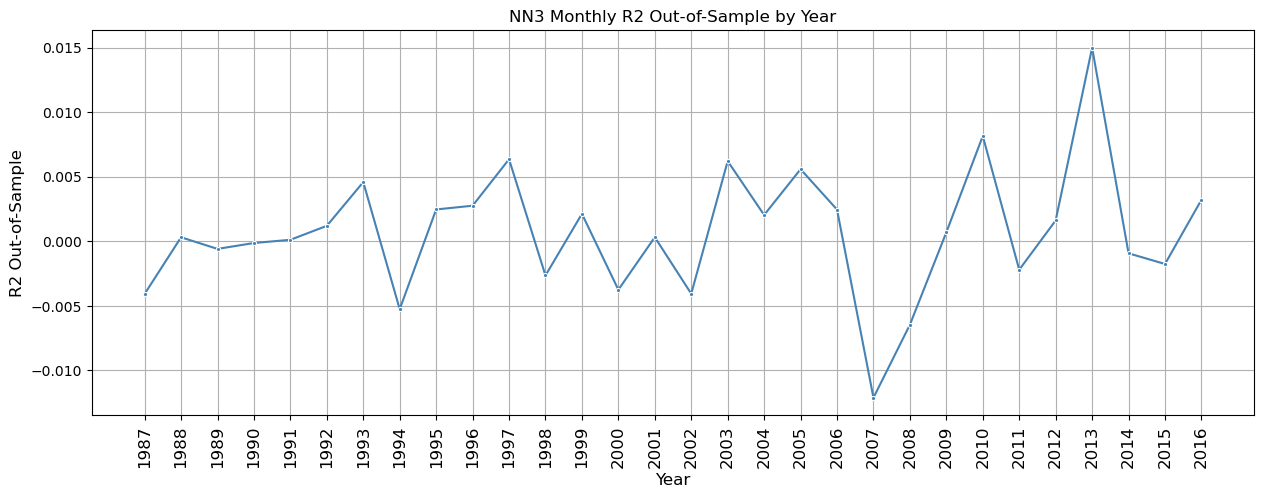

In [46]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='Year', y='NN3_R2oos', data=NN3_R2oos_no_demeaning_df, color='steelblue', marker='.')
plt.title('NN3 Monthly R2 Out-of-Sample by Year', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('R2 Out-of-Sample', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.grid()
plt.show()

### Training NN4

In [47]:
NN4_config_search_space_dict = {
    "seed": [9],
    "input_dim": [105],
    "output_dim": [1],
    "num_layers": [4],
    "max_hidden_dim": [32],
    "activation": ["ReLU"],
    "w_init": [False],
    "criterion": ["MSELoss"],
    "optimizer": ["Adam"],
    "weight_decay": [0],
    "learning_rate": [0.01, 0.001],
    "regularization": ["L1"],
    "reg_lambda": [0.01, 0.001],
    "batch_size": [10000],
    "num_epochs": [100],
    "patience": [5],
}
NN4_config_search_space_dict_list = list(ParameterGrid(NN4_config_search_space_dict))

In [48]:
NN4_performance_and_model_dict = {}

In [ ]:
NN4_performance_and_model_dict = recursive_NN_trainer(data_df, 
                                                    NN4_performance_and_model_dict, 
                                                    NN4_config_search_space_dict_list, 
                                                    recursion_range = 30, 
                                                    train_time_span = 29, 
                                                    val_time_span = 1, 
                                                    test_time_span = 1, 
                                                    training_verbose = False)
# model check point
# with open('NN4_performance_and_model_dict.pkl', 'wb') as f:
#     pickle.dump(NN4_performance_and_model_dict, f)

In [50]:
NN4_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in NN4_performance_and_model_dict.items()}
NN4_R2oos_no_demeaning_df = pd.DataFrame(list(NN4_R2oos_no_demeaning_dict.items()), columns=['Year', 'NN4_R2oos']).sort_values(by='Year', ascending=True)

In [51]:
NN4_R2oos_no_demeaning_mean = np.mean([value for key, value in NN4_R2oos_no_demeaning_dict.items()])
print(f"Mean R2oos_no_demeaning: {NN4_R2oos_no_demeaning_mean}")

Mean R2oos_no_demeaning: -0.00010992520314111095


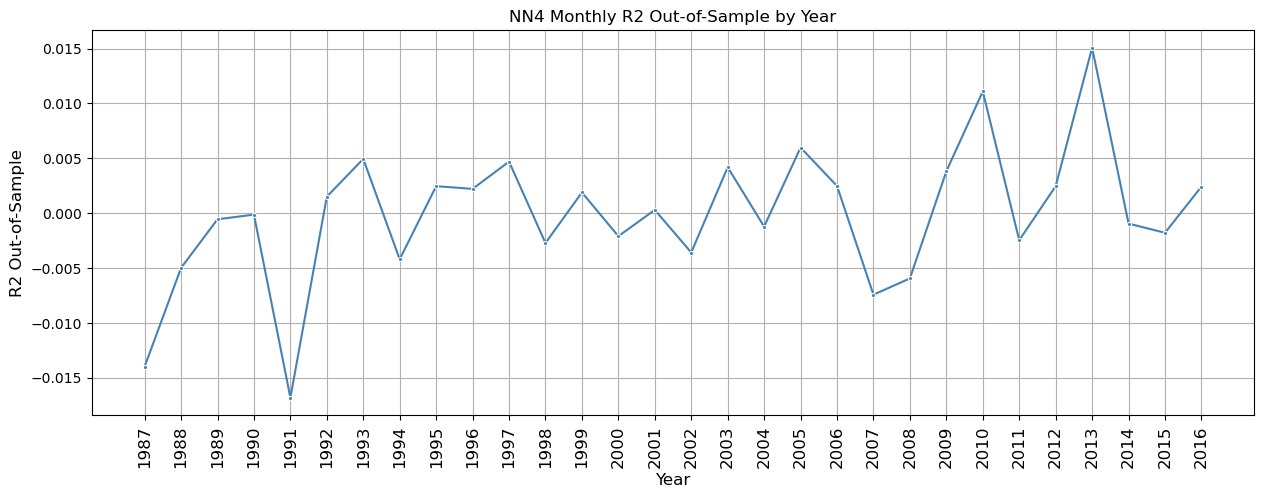

In [52]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='Year', y='NN4_R2oos', data=NN4_R2oos_no_demeaning_df, color='steelblue', marker='.')
plt.title('NN4 Monthly R2 Out-of-Sample by Year', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('R2 Out-of-Sample', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.grid()
plt.show()

# Questions 2

*Use test data to get an idea of the out of sample performance of each model. Convert the standard MSE metric for out of sample performance to the “R2 out of sample” metric that was discussed in class. Compare your results to those in Gu-Kelly-Xiu and comment on the differences.*

In [14]:
# # load model check points if previously saved
# NN2_performance_and_model_dict = pickle.load(open('NN2_performance_and_model_dict.pkl', 'rb'))
# NN3_performance_and_model_dict = pickle.load(open('NN3_performance_and_model_dict.pkl', 'rb'))
# NN4_performance_and_model_dict = pickle.load(open('NN4_performance_and_model_dict.pkl', 'rb'))

In [15]:
NN2_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in NN2_performance_and_model_dict.items()}
NN2_R2oos_no_demeaning_df = pd.DataFrame(list(NN2_R2oos_no_demeaning_dict.items()), columns=['Year', 'NN2_R2oos']).sort_values(by='Year', ascending=True)
NN2_R2oos_no_demeaning_df['Year'] = NN2_R2oos_no_demeaning_df['Year'].astype('int')
NN2_R2oos_no_demeaning_mean = NN2_R2oos_no_demeaning_df['NN2_R2oos'].mean()
print(f"NN2 Mean R2oos_no_demeaning : {round(NN2_R2oos_no_demeaning_mean,8)*100}%")

NN2 Mean R2oos_no_demeaning : -0.033557%


In [16]:
NN3_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in NN3_performance_and_model_dict.items()}
NN3_R2oos_no_demeaning_df = pd.DataFrame(list(NN3_R2oos_no_demeaning_dict.items()), columns=['Year', 'NN3_R2oos']).sort_values(by='Year', ascending=True)
NN3_R2oos_no_demeaning_df['Year'] = NN3_R2oos_no_demeaning_df['Year'].astype('int')
NN3_R2oos_no_demeaning_mean = NN3_R2oos_no_demeaning_df['NN3_R2oos'].mean()
print(f"NN3 Mean R2oos_no_demeaning : {round(NN3_R2oos_no_demeaning_mean,8)*100}%")

NN3 Mean R2oos_no_demeaning : 0.07163900000000001%


In [17]:
NN4_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in NN4_performance_and_model_dict.items()}
NN4_R2oos_no_demeaning_df = pd.DataFrame(list(NN4_R2oos_no_demeaning_dict.items()), columns=['Year', 'NN4_R2oos']).sort_values(by='Year', ascending=True)
NN4_R2oos_no_demeaning_df['Year'] = NN4_R2oos_no_demeaning_df['Year'].astype('int')
NN4_R2oos_no_demeaning_mean = NN4_R2oos_no_demeaning_df['NN4_R2oos'].mean()
print(f"NN4 Mean R2oos_no_demeaning : {round(NN4_R2oos_no_demeaning_mean,8)*100}%")

NN4 Mean R2oos_no_demeaning : -0.010993%


In [18]:
all_NNs_R2oos_no_demeaning_df = pd.merge(pd.merge(NN2_R2oos_no_demeaning_df, NN3_R2oos_no_demeaning_df, on='Year', how='outer'), NN4_R2oos_no_demeaning_df, on='Year', how='outer')
df_melted = all_NNs_R2oos_no_demeaning_df.melt(id_vars=['Year'], var_name='Model', value_name='R2_oos')

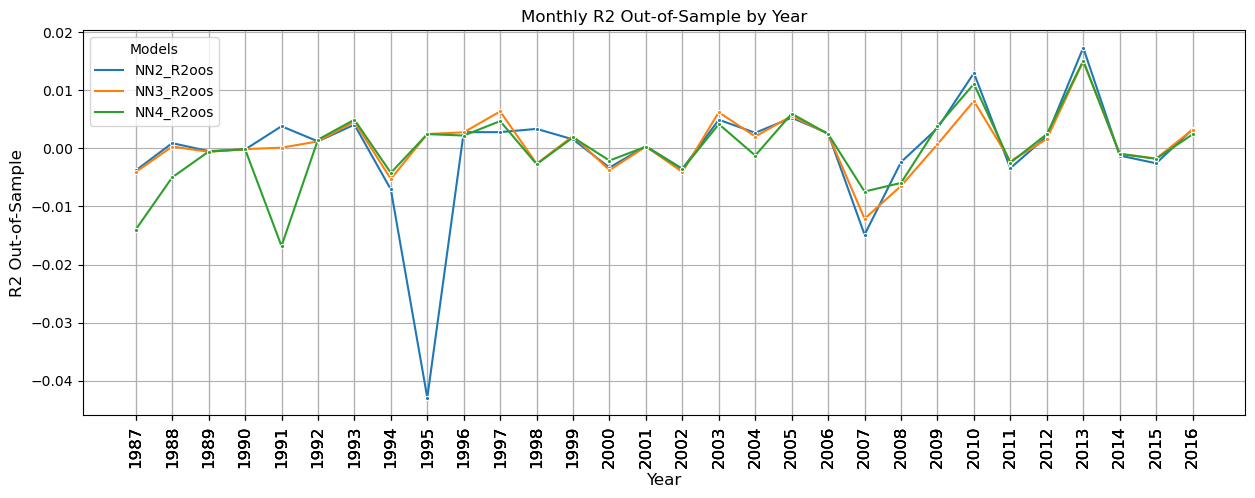

In [19]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='Year', y='R2_oos', hue='Model', data=df_melted, marker='.', palette='tab10')

plt.title('Monthly R2 Out-of-Sample by Year', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('R2 Out-of-Sample', fontsize=12)
plt.xticks(rotation=90, fontsize=12, ticks=df_melted['Year'])
plt.grid()

plt.legend(title='Models')
plt.show()

**Parameters and Configurations for training**

| Configuration | Our Specification| GKX Specification |
| --------:| --------:|--------:|
| **Regularisation**| $L1$ penalty | $L1$ penalty|
| **Regularisation Penalty**| $\lambda_1 \in \{10^{-3},10^{-2}\}$ | $\lambda_1 \in (10^{-5},10^{-3})$|
| **Optimiser** | Adam |Adam |
| **Optimiser Parameter** | Default |Default |
| **Activation** | ReLU | ReLU | 
| **Learning Rate** | $ LR \in \{10^{-3},10^{-2}\}$ | $ LR \in \{10^{-3},10^{-2}\}$ |
| **Batch Size** | 10000 |10000 |
| **Epochs** | 100 |100 |
| **$ MSE_{train} $ Patience** | 5 |5 |
| **Validate on** | $R_{validation}^2$ | $ MSE_{validation} $ |
| **Test on** | $R_{oos}^2$ | $R_{oos}^2$ |
| **Ensemble** | 1 |10 |
| **Recursion Refit** | True | True |
| **Time** | 1957-2016 | 1957-2016 |
| **Training Span** | 30 (expanding)| 18 (expanding)|
| **Validation Span** | 1 (rolling) | 12 (rolling)|
| **Testing Span** | 1*29 (rolling)| 1*30 (rolling)|

**Performance**

| **Monthly percentage $R_{oos}^2$** | **Our NNs** | **GKX NNs** |
| --------:| --------:|--------:|
| **NN2** | -0.034 | 0.39 |
| **NN3** | 0.072 | 0.40 |
| **NN4** | -0.011 | 0.39 |

- Our models show generally lower $R_{oos}^2$ values compared to GKX NNs. This difference is likely due to the narrower hyperparameter search space we utilized, as we are facing computational constraints.
- However, one notable similarity is that **both our and GKX's NN3 performed the best** among the respective NN set, achieving monthly percentage $R_{oos}^2$ values of 0.072% and 0.40% respectively. This indicates that NN3 might be inherently more robust in predicting returns.
- From the Monthly $R_{oos}^2$ by Year plot, we can see that NN3's performance is not due to numerous significant positive $R_{oos}^2$ values, but rather due to fewer negative $R_{oos}^2$ values. While NN2 outperformed NN3 in certain years, it also experienced extreme negative $R_{oos}^2$. In contrast, NN3 demonstrated more consistent and stable performance.

**Some Major Differences**
- **Ensemble**
    - GKX uses an ensemble of 10, while we use 1. Ensembling typically improves model robustness and predictive performance by averaging out the errors of individual models, which likely explains part of the performance gap.
    - During development, we found that NN models are **extremely** sensitive to the seed. This sensitivity might explain why GKX's ensemble of 10  achieved better results. Due to computational constraints, we were unable to conduct extensive ensembles.
    
- **Reularisation Penalty**
    - GKX uses a wider range of $\lambda_1$ values ($10^{-5}$ to $10^{-3}$), which could contribute to better model regularization and performance. Our range $\lambda_1 \in \{10^{-3},10^{-2}\}$ may not be as effective in preventing overfitting or underfitting because there are only two $\lambda_1$ to validate on.

- **Training, Validation, and Testing Spans**
    - Our training span is 30 years compared to GKX’s 18 years. A longer training period might introduce more noise and variability, especially if the underlying data distribution changes over time.
    - Our validation span is only 1 year, while GKX uses 12 years, providing them with a more stable validation process that can better inform model tuning.
    - We chose to hyperparameter optimize each year during every refit, similar to GKX, but with a different validation method. While we validated on $R_{validation}^2$, they validated on $MSE_{validation}$. Because we comparing $R_{oos}^2$ at the end, we believed this could improve our result but this could have impacted the effectiveness of our hyperparameter tuning and model performance.
    - We chose to validate on only one year to accelerate the process and put the model into testing earlier, aiming to produce a positive $R_{oos}^2$. However, this shorter validation span may not provide a stable basis for model evaluation and optimization, potentially leading to less robust model performance.




# Questions 3

*3.	Pick the model that performs the best out of sample, and interpret its output by doing the following analysis of variable importance:*

## Questions 3a

*a.	First, for all stock characteristics, get variable importance by setting one predictor at a time to zero and finding the decrease in out of sample R2. Show a table of the 10 most important variables according to this measure, and give an economic interpretation.*

**Our implementation remarks:**

- Model: NN3 
- Time range: 1987-2016
- Method: We followed GKX method which calculate the reduction in $R^{2}_{oos}$ from setting all values of a given predictor to zero within each training sample and average these into a single importance measure for each predictor.

In [20]:
def rebuild_model_from_state_dict(config_dict, state_dict):
    '''
    rebuild model from trained model state_dict
    '''
    device = "cuda" if torch.cuda.is_available() else "cpu"

    seed = config_dict["seed"]
    input_dim = config_dict["input_dim"]
    output_dim = config_dict["output_dim"]
    num_layers = config_dict["num_layers"]
    max_hidden_dim = config_dict["max_hidden_dim"]
    activation = config_dict["activation"]
    w_init = config_dict["w_init"]
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    model = NN_Flexiable(
        input_dim=input_dim,
        output_dim=output_dim,
        num_layers=num_layers,
        max_hidden_dim=max_hidden_dim,
        activation=activation,
        w_init=w_init,
    )
    model.load_state_dict(state_dict)
    model.to(device) # load trained model_state_dict
    return model

In [21]:
def chara_variable_importance(model, year, data_df, R2_oos_best, stock_chara_panel_df) -> dict:
    '''
    calculate variable importance (decrease in R2oos)
    '''
    device = "cuda" if torch.cuda.is_available() else "cpu"
    _, _, _, _, X_test, y_test, _ = (
        generate_recursive_dataset(
            data_df,
            i_th_recursion = year - 1957 - 18 - 1,
            train_time_span=18,
            val_time_span=1,
            test_time_span=1,
            verbose=False
        )
    )
    column_list_cleaned = [col for col in data_df.columns if col not in ["ret", "excess_ret", "rfree", "permno", "date"]]
    chara_94_list = [col for col in stock_chara_panel_df.columns if col not in ["ret", "excess_ret", "rfree", "permno", "date"]]
    variable_importance_dict = {}

    for variable in chara_94_list:

        X_test_df = pd.DataFrame(X_test, columns=column_list_cleaned)
        X_test_df = X_test_df.rename(columns={'ep_chara':'ep'})
        X_test_df[variable] = 0.0
        
        X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

        R2_oos = R2_no_demeaning_NN(model, X_test_tensor, y_test_tensor, device)*100
        decrease_in_R2 = R2_oos_best*100 - R2_oos
        # print(f"decrease in % R2: {decrease_in_R2}")
        variable_importance_dict[variable] = decrease_in_R2
    return variable_importance_dict

In [22]:
def chara_variable_importance_all_year(NN3_performance_and_model_dict):
    chara_variable_importance_all_year_dict = {}
    for year in tqdm(range(1987, 2016+1)):
        # NN3_performance_and_model_dict = pickle.load(open('NN3_performance_and_model_dict.pkl', 'rb')) check points
        NN3_R2oos_no_demeaning = NN3_performance_and_model_dict[str(year)]['R2oos_no_demeaning']
        NN3_best_config = NN3_performance_and_model_dict[str(year)]['best_config']
        NN3_best_model_state = NN3_performance_and_model_dict[str(year)]['best_model_state_dict']
        NN3_model = rebuild_model_from_state_dict(NN3_best_config, NN3_best_model_state)
        
        chara_variable_importance_all_year_dict[year] = chara_variable_importance(NN3_model, year, data_df, NN3_R2oos_no_demeaning, stock_chara_panel_df)
    return chara_variable_importance_all_year_dict

In [23]:
def overall_variable_importance(chara_variable_importance_all_year_dict):
    cumulative_drop_in_r2 = {}
    count_drop_in_r2 = {}
    for year, variables in chara_variable_importance_all_year_dict.items():
        for variable, drop_in_r2 in variables.items():
            if variable not in cumulative_drop_in_r2:
                cumulative_drop_in_r2[variable] = 0
                count_drop_in_r2[variable] = 0
            cumulative_drop_in_r2[variable] += drop_in_r2
            count_drop_in_r2[variable] += 1

    chara_variable_overall_importance_dict = {variable: cumulative_drop_in_r2[variable] / count_drop_in_r2[variable] for variable in cumulative_drop_in_r2}
    return chara_variable_overall_importance_dict

In [24]:
chara_variable_importance_all_year_dict = chara_variable_importance_all_year(NN3_performance_and_model_dict)

100%|██████████| 30/30 [03:21<00:00,  6.73s/it]


In [25]:
overall_chara_variable_importance_dict = overall_variable_importance(chara_variable_importance_all_year_dict)

In [26]:
chara_variable_importance_df = pd.DataFrame(list(overall_chara_variable_importance_dict.items()), columns=['Variable', 'Decrease_in_percentage_R2oos'])
chara_variable_importance_df.sort_values(by='Decrease_in_percentage_R2oos', ascending=False, inplace=True)

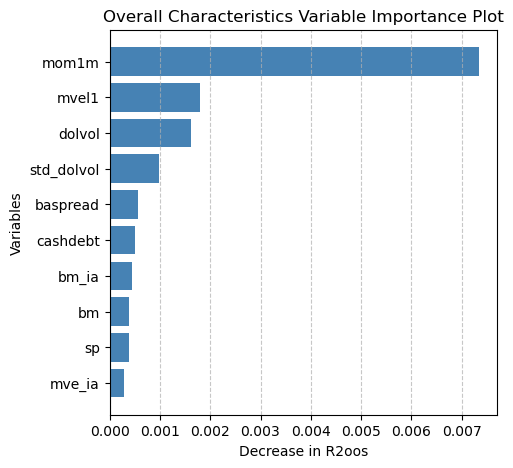

In [27]:
plt.figure(figsize=(5, 5))
plt.barh(chara_variable_importance_df['Variable'][0:10], chara_variable_importance_df['Decrease_in_percentage_R2oos'][0:10], color='steelblue')
plt.xlabel('Decrease in R2oos')
plt.ylabel('Variables')
plt.title('Overall Characteristics Variable Importance Plot')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

**Economic Interpretation for NN3's Important Predictor**

- 1-month Momentum (`mom1m`):
    - This is the most significant predictor, indicating that recent performance trends are critical in forecasting future stock behavior. This aligns with investor behavior where past winners tend to continue performing well. This result is consistent with GKX's findings where 1-month momentum is the most important predictor for all of their model.

- Size (`mvel1`):
    - Larger firms show more predictable patterns due to stable earnings, better access to capital, and diversified operations. This result is also consistent with GKX's result where Size is second important predictor.

- Dollar Trading Volume (`dolvol`):
    - Highlights the importance of liquidity, as higher trading volumes suggest more investor interest and reliable pricing.

- Volatility of liquidity (dollar trading volume) (`std_dolvol`):
    - Stable liquidity conditions are crucial for firms overall financial condition. Therefore volatility of Liquidity is important for consistent pricing. 

- Bid-Ask Spread (`baspread`):
    - Lower spreads indicate higher market efficiency and lower transaction costs, contributing to better stock performance and predictability

- Cashflow to Debt (`cashdebt`):
    - This metric assesses a firm's ability to cover its debt with its cash flow, also indicating financial health and potential for stable returns.

- Industry-Adjusted Book to Market (`bm_ia`):
    - Relative valuation within an industry matters, with stocks valued favorably compared to peers performing better.

- Book-to-Market (`bm`):
    - Indicates traditionally valued firms (high book-to-market) tend to be more predictable and provide stable returns.

- Sales to Price (`sp`):
    - Firms with higher sales relative to their price might be overvalued, indicating potential for lower future returns.

- Industry-adjusted size (`mve_ia`):
    - Larger firms within an industry, adjusted for their specific sector, tend to show more predictable patterns and stability.

Overall, the R2oos variable importance is similar to the result from GKX. 

## Questions 3b

b.	Second, get a measure of the joint importance of all our “macro predictors” (i.e., those taken from Welch and Goyal 2008), by setting them all to zero and finding the decrease in out of sample R2. Comment on how important macroeconomic variables are relative to stock characteristics in predicting returns. 

In [28]:
def joint_macro_variable_importance(model, year, data_df, R2_oos_best, macro_ts_df) -> dict:
    '''
    calculate variable importance (decrease in R2oos)
    '''
    device = "cuda" if torch.cuda.is_available() else "cpu"
    _, _, _, _, X_test, y_test, _ = (
        generate_recursive_dataset(
            data_df,
            i_th_recursion = year - 1957 - 18 - 1,
            train_time_span=18,
            val_time_span=1,
            test_time_span=1,
            verbose=False
        )
    )
    column_list_cleaned = [col for col in data_df.columns if col not in ["ret", "excess_ret", "rfree", "permno", "date"]]
    marco_list = [col for col in macro_ts_df.columns if col not in ["date"]]
    variable_importance_dict = {}

    X_test_df = pd.DataFrame(X_test, columns=column_list_cleaned)
    X_test_df = X_test_df.rename(columns={'ep_macro':'ep'})
    X_test_df[marco_list] = 0.0
    X_test_tensor = torch.tensor(X_test_df.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    R2_oos = R2_no_demeaning_NN(model, X_test_tensor, y_test_tensor, device)*100
    decrease_in_R2 = R2_oos_best*100 - R2_oos
    # print(f"decrease in % R2: {decrease_in_R2}")
    return decrease_in_R2

In [29]:
def joint_macro_variable_importance_all_year(NN3_performance_and_model_dict):
    macro_variable_importance_all_year_dict = {}
    for year in tqdm(range(1987, 2016+1)):
        # NN3_performance_and_model_dict = pickle.load(open('NN3_performance_and_model_dict.pkl', 'rb')) check points
        NN3_R2oos_no_demeaning = NN3_performance_and_model_dict[str(year)]['R2oos_no_demeaning']
        NN3_best_config = NN3_performance_and_model_dict[str(year)]['best_config']
        NN3_best_model_state = NN3_performance_and_model_dict[str(year)]['best_model_state_dict']
        NN3_model = rebuild_model_from_state_dict(NN3_best_config, NN3_best_model_state)
        
        macro_variable_importance_all_year_dict[year] = joint_macro_variable_importance(NN3_model, year, data_df, NN3_R2oos_no_demeaning, macro_ts_df)
    return macro_variable_importance_all_year_dict

In [30]:
macro_variable_importance_all_year_dict = joint_macro_variable_importance_all_year(NN3_performance_and_model_dict)

100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


In [31]:
joint_macro_variable_overall = sum(macro_variable_importance_all_year_dict.values()) / len(macro_variable_importance_all_year_dict)
print(f"Joint Macro Variable Importance: {joint_macro_variable_overall}")

Joint Macro Variable Importance: 0.032247932017306725


The overall joint importance of macro predictors measured by setting them all to zero is 0.032. 

This indicates that macroeconomic variables significantly contribute to predicting stock returns. While stock-specific factors such as momentum, size, and liquidity play an important role, the macroeconomic environment holds substantial predictive power and is more crucial to model prediction than the top 10 characteristic variables combined. This is because macro predictors capture broader economic trends that can impact overall market performance.

## Questions 3c

*Repeat the two steps above, but by using a measure of the sensitivity of predictions to each input variable, as outlined in the lectures.*

**Our implementation remarks:**

- Model: NN3 
- Time range: 1987-2016
- Method: We followed GKX method which calculate the sum of squared partial derivatives (SSD) as sensitivity measurement of model to each variable. We choose to analyse macroeconomic and firm characteristics variables togather for comparison.

In [32]:
def variable_importance_SSD(model, year, data_df, stock_chara_panel_df):
    '''
    Calculate variable importance using the sum of squared partial derivatives (SSD)
    '''
    device = "cuda" if torch.cuda.is_available() else "cpu"
    _, _, _, _, X_test, y_test, _ = generate_recursive_dataset(
        data_df,
        i_th_recursion=year - 1957 - 18 - 1,
        train_time_span=18,
        val_time_span=1,
        test_time_span=1,
        verbose=False
    )

    column_list_cleaned = [col for col in data_df.columns if col not in ["ret", "excess_ret", "rfree", "permno", "date"]]
    variable_importance_dict = {}

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    X_test_tensor.requires_grad = True  # Enable gradients for input
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    model.eval()  

    y_pred = model(X_test_tensor)

    # gradients of the prediction output w.r.t each input feature
    grads = grad(y_pred.sum(), X_test_tensor, create_graph=True)[0]

    for idx, variable in enumerate(column_list_cleaned):
        # Sum of squared partial derivatives (SSD)
        SSD = (grads[:, idx] ** 2).sum().item()
        variable_importance_dict[variable] = SSD

    return variable_importance_dict

def variable_importance_all_year_SSD(data_df, NN3_performance_and_model_dict):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    variable_importance_all_year_dict = {}
    for year in tqdm(range(1987, 2016 + 1)):
        # NN3_performance_and_model_dict = pickle.load(open('NN3_performance_and_model_dict.pkl', 'rb')) check points
        NN3_best_config = NN3_performance_and_model_dict[str(year)]['best_config']
        NN3_best_model_state = NN3_performance_and_model_dict[str(year)]['best_model_state_dict']
        NN3_model = rebuild_model_from_state_dict(NN3_best_config, NN3_best_model_state)
        
        variable_importance_all_year_dict[year] = variable_importance_SSD(NN3_model, year, data_df, device)
    return variable_importance_all_year_dict

def overall_variable_importance_SSD(variable_importance_all_year_dict):
    cumulative_ssd = {}
    count_ssd = {}
    for year, variables in variable_importance_all_year_dict.items():
        for variable, ssd in variables.items():
            if variable not in cumulative_ssd:
                cumulative_ssd[variable] = 0
                count_ssd[variable] = 0
            cumulative_ssd[variable] += ssd
            count_ssd[variable] += 1

    variable_overall_importance_dict = {variable: cumulative_ssd[variable] / count_ssd[variable] for variable in cumulative_ssd}
    return variable_overall_importance_dict

In [33]:
variable_importance_all_year_dict_SSD = variable_importance_all_year_SSD(data_df, NN3_performance_and_model_dict)
variable_overall_importance_dict_SSD = overall_variable_importance_SSD(variable_importance_all_year_dict_SSD)

100%|██████████| 30/30 [00:55<00:00,  1.86s/it]


In [34]:
variable_importance_SSD_df = pd.DataFrame(list(variable_overall_importance_dict_SSD.items()), columns=['Variable', 'SSD'])
variable_importance_SSD_df.sort_values(by='SSD', ascending=False, inplace=True)

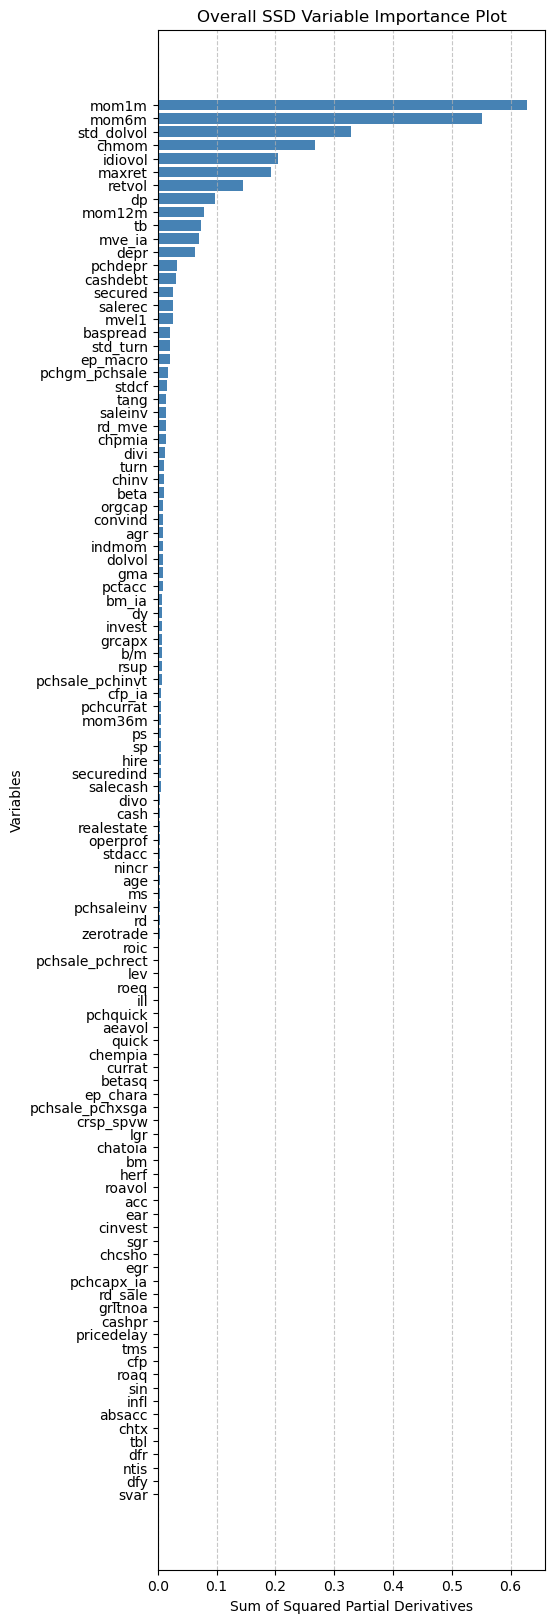

In [35]:
plt.figure(figsize=(5, 20))
plt.barh(variable_importance_SSD_df['Variable'], variable_importance_SSD_df['SSD'], color='steelblue')
plt.xlabel('Sum of Squared Partial Derivatives')
plt.ylabel('Variables')
plt.title('Overall SSD Variable Importance Plot')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The top variables from SSD are 1-month momentum (`mom1m`) and 6-month momentum (`mom6m`) which is similar to the R2 variable importance emphasizing the significance of recent performance trends. The volatility of liquidity (`std_dolvol`) also plays a crucial role, indicating that stable trading volumes are vital for predictability. Additional important variables include change in 6-month momentum (`chmom`), idiosyncratic volatility (`idivol`), and market daily return (`maxret`), indicating the influence of momentum, liquidity, and market conditions.

# Questions 4

*Fit a penalised linear model (LASSO) to the same data, using validation data to pick the best penalty (e.g., you can use the “sklearn” package in Python to do this easily). Compare its test data performance to the neural network.*

In [36]:
def R2oos_lasso_no_demeaning(y_true, y_pred):
    '''
    calculate R2oos without demeaning (GKX 2019 implementation)
    '''
    y_true = y_true
    y_pred = y_pred
    error = y_true - y_pred
    numerator = np.sum(np.power(error, 2))
    denominator = np.sum(np.power(y_true, 2))
    return 1 - (numerator / denominator)

# Recursive training function for LASSO
def recursive_lasso_trainer(data_df, lambda_values, recursion_range=30, train_time_span=29, val_time_span=1, test_time_span=1):
    results = {}

    for i_th_recursion in tqdm(range(recursion_range)):
        X_train, y_train, X_val, y_val, X_test, y_test, meta_data_dict = generate_recursive_dataset(
            data_df,
            i_th_recursion=i_th_recursion,
            train_time_span=train_time_span,
            val_time_span=val_time_span,
            test_time_span=test_time_span
        )

        best_lambda = None
        best_val_loss = float('inf')
        best_model = None

        # Loop over each lambda value to find the best one based on validation performance
        for lambda_value in lambda_values:
            lasso = Lasso(alpha=lambda_value, max_iter=1000, random_state=seed)
            lasso.fit(X_train, y_train.squeeze())

            y_val_pred = lasso.predict(X_val)
            val_score = mean_squared_error(y_val.squeeze(), y_val_pred)

            if val_score < best_val_loss:
                best_val_loss = val_score
                best_lambda = lambda_value
                best_model = lasso

        y_pred_test = best_model.predict(X_test)

        R2oos_no_demeaning = R2oos_lasso_no_demeaning(y_test.squeeze(), y_pred_test)

        oos_year = meta_data_dict['test_start_time'][:4]
        results[oos_year] = {
            "best_alpha": best_lambda,
            "best_val_loss": best_val_loss,
            "R2oos_no_demeaning": R2oos_no_demeaning,
            "n_features": np.sum(best_model.coef_ != 0),
        }
    return results

In [37]:
lambda_values = [0.01, 0.001]
lasso_results_dict = recursive_lasso_trainer(data_df, lambda_values)

100%|██████████| 30/30 [03:04<00:00,  6.14s/it]


In [38]:
lasso_R2oos_no_demeaning_dict = {key: value["R2oos_no_demeaning"] for key, value in lasso_results_dict.items()}
lasso_R2oos_no_demeaning_df = pd.DataFrame(list(lasso_R2oos_no_demeaning_dict.items()), columns=['Year', 'LASSO_R2oos']).sort_values(by='Year', ascending=True)

In [39]:
LASSO_R2oos_no_demeaning_mean = np.mean([value for key, value in lasso_R2oos_no_demeaning_dict.items()])
print(f"LASSO Mean R2oos_no_demeaning : {round(LASSO_R2oos_no_demeaning_mean,8)*100}%")

LASSO Mean R2oos_no_demeaning : 0.215626%


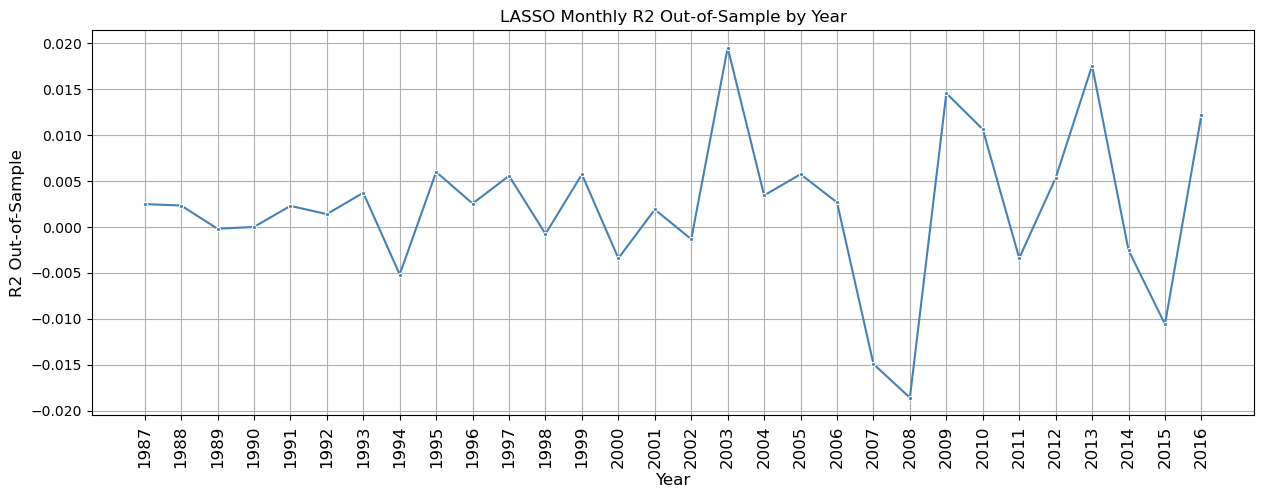

In [40]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='Year', y='LASSO_R2oos', data=lasso_R2oos_no_demeaning_df, color='steelblue', marker='.')
plt.title('LASSO Monthly R2 Out-of-Sample by Year', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('R2 Out-of-Sample', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.grid()
plt.show()

**Performance**

| **Monthly percentage $R_{oos}^2$** | **Our Result** | **GKX Result** |
| --------:| --------:|--------:|
| **NN2** | -0.034 | 0.39 |
| **NN3** | 0.072 | 0.40 |
| **NN4** | -0.011 | 0.39 |
| **LASSO** | 0.216 | 0.19 (Huber loss) |

Our NN models (NN2, NN3, NN4) all underperform compared to GKX NNs, with NN2 and NN4 even showing negative $R_{oos}^2$. In contrast, our LASSO achieved a higher $R_{oos}^2$ of 0.216, above GKX's LASSO trained using Huber loss, though still below GKX NNs. The underperformance of our NNs is likely due to the narrower hyperparameter search space we utilized as we are facing computational constraints.

# Questions 5

*Suppose somebody tells you to collect 10 more micro or macro variables that can predict returns and are not in our current dataset. How would you choose those variables, based on the intuitions you have gained in this project?*

**10 More variables**

- **Micro variables**

    - **Measure of Employee Satisfaction**: Employee satisfaction can be measured by factors such as salaries, working hours, or questionnaires. A higher level of employee satisfaction can indicate strong corporate management and a positive workplace culture. This correlates with the stability and discipline of the company, generating more confidence from investors. Companies with high employee satisfaction are likely to perform better, be more productive, and achieve long-term success.

    - **Number of Patents**: The number of patents can be seen as a sign of industry barriers, especially in technological sectors. Patents create a monopoly position by making it harder for others to enter the market. They also reflect a company's creativity and robust pipeline of products and innovations, contributing to user loyalty, ensuring future revenue streams, and positively influencing stock prices.

- **Macro variables**

    - **FED Announcement**: Changes in interest rates affect almost all aspects of the economy, from consumer spending to corporate borrowing. Lower interest rates typically encourage borrowing and expansion, boosting stock prices, while higher rates may slow down excessive economic growth and stock market exuberance. FED announcements have long been crucial indicators for financial institutions.

    - **Geopolitical Risk**: Changes in political landscapes, especially in major economies, can significantly affect market perceptions and economic forecasts. *The Presidential Puzzle: Political Cycles and the Stock Market, Santa Clara and Rossen Valkanov, 2003* have argued that the excess return in the stock market is higher under Democratic than Republican presidencies. This is caused by different government policies and it might influence business environments, regulatory landscapes, and consumer confidence.

    - **Sentiment Analysis**: Natural Language Processing (NLP) has advanced to the point where machines can analyze policies, financial news, press releases, business reports, and even social media posts. This information can be transformed into numerical data using NLP, and machine learning can help identify relationships, such as a positive article leading to an increase in stock prices. Such sentiment analysis can indicate market confidence about the future.

    - **Climate and Natural Disaster**: Natural disasters like hurricanes and earthquakes can cause significant losses for affected companies and industries such as insurance, agriculture, and energy. Factors used for catastrophe bonds, such as the distance of a tornado or the probability of a volcanic eruption, can also apply to the stock market. Predicting these events and understanding their likely impact on relevant sectors can guide investment decisions and manage systematic risk.

    - **Gold Prices**: Gold is considered a safe haven during times of economic uncertainty or market volatility. Investors trade real gold or derivatives underlying on gold as hedging assets for a long time. When the economic environment is bad, people refuse to put their money in the stock market and invest in gold raising the gold price. There are a few studies that already prove that gold price is negatively related to stock prices in a long term scale.

    - **National Debt Level**: The national debt level can signal the overall economic health of a country. A high debt position may prompt the government to implement policies that negatively affect the market, such as increased taxation or cuts in public spending, both of which reduce business profits. Monitoring national debt levels can help forecast government fiscal policies and their impacts on investment and economic conditions, especially considering some countries have recently declared bankruptcy.

    - **Export and Import Figures**: The volume and value of import and export on specific commodities can provide insights of demand and supply for different industries. For example, a higher import volume of silicon may caused by a larger demand of semiconductor industry. Analyzing specific commodity flows can help predict performances in specific sector such as manufacturing, technology and consumer goods.

    - **Trade Deficit**: The balance between exports and imports reflects the economic condition of specific country. A favorable balance usually indicates a strong economy and a favorable exchange rate, suggesting that domestic companies have a price advantage over foreign competitors. This can lead to higher sales and profits, positively impacting stocks for a specific country or a market index.


